# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import time
import numpy as np

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [ ]:
SEED = 1

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [31]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


### 4. Time to put some Intelligence into Actions!

Now it's time to train our agent to solve the environment!  When training the environment, we set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [73]:
C_EPISODES = 100 # consecutive episodes

agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)

In [74]:
def ddpg(n_episodes=1000, max_t=1000, print_every=10):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    scores_window = deque(maxlen=100)
    scores_all = []
    moving_average = []
    best_score = -np.inf
    best_episode = 0
    solved = False
    c_states = state_size * 2 # combine states
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # (1) reset environment
        states = env_info.vector_observations                   # (2) get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # (3) send actions to environment
            next_states = env_info.vector_observations          # (4) get next state
            rewards = env_info.rewards                          # (5) get reward
            dones = env_info.local_done                         # (6_ see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
#             for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones): 
#                 agent.step(state, action, reward, next_state, done, t)
            for i in range(0, num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            states = next_states
            scores += np.max(rewards)        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        ep_best = np.max(scores)
        scores_window.append(ep_best)       # save mean score to window
        scores_all.append(ep_best)
        moving_average.append(np.mean(scores_window))  # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\Max: {:.1f}\tMoving Avg: {:.1f}'.format(\
                  i_episode, round(duration), ep_best, moving_average[-1]))
                  
        if moving_average[-1] >= 0.5: # Reached goal?
            if not solved:
                print('\n\tEnvironment solved in {:d} episodes! \
                \n\tMoving Average: {:.3f} (over past {:d} episodes)\n'.format(
                    i_episode-C_EPISODES, moving_average[-1], C_EPISODES))
                solved = True
                
                torch.save(agent.actor_local.state_dict(), "weights/actor_ckpt.pth")
                torch.save(agent.critic_local.state_dict(), "weights/critic_ckpt.pth")
                
            elif ep_best >= best_score:
                torch.save(agent.actor_local.state_dict(),  "weights/actor_ckpt.pth")
                torch.save(agent.critic_local.state_dict(), "weights/critic_ckpt.pth")
                
            elif (i_episode - best_episode) >= 200:
                print('\n\tTraining stopped: best score stale for 200 episodes.')
                break
                
            else:
                continue
            
    return scores_all, moving_average

In [75]:
start = time.time()

In [76]:
# run the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)
scores, avgs = ddpg()

# Environment solved in 296 episodes!	Average Score: 30.03

Episode 10 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 20 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 30 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 40 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 50 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 60 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 70 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 80 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 90 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 100 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 110 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 120 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 130 (1s)\Max: 0.1	Moving Avg: 0.0
Episode 140 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 150 (1s)\Max: 0.1	Moving Avg: 0.0
Episode 160 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 170 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 180 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 190 (0s)\Max: 0.0	Moving Avg: 0.0
Episode 200 (0s)\Max: 0.0	Moving Avg: 0.1
Episode 210 (0s)\Max: 0.0	Moving Avg: 0.1
Episode 220 (0s)\Max: 0.0	Moving Avg: 0.1
Episode 230 (0s)\Max: 0.0	Moving Avg: 0.1
Episode 240 (1s)\Max: 0.2	Moving Avg: 0.1
E

In [77]:
end = time.time()
elapsed = (end - start) / 60.0 # in minutes
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed)) # 223.58 mins.


Elapsed Time: 6.78 mins.


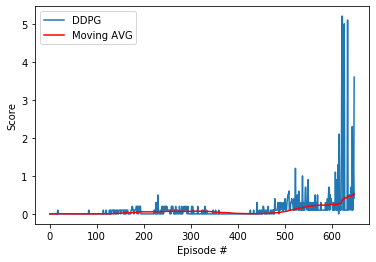

In [80]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

When finished, you can close the environment.

In [ ]:
env.close()